### Training
#### Check number of training examples. Scraping from Google images.
<li> Dogs: Various searches of types, puppies and dog in hot dog costumes which is fun to compare against. </li>
<li> HotDogs: Tried to clean data to show typical hot dog and cropped to not include other food (fries). </li>
<li> NotDog: Random image search using mostly personal images uploaded with name IM####.jpg - by inspection mostly of people. Used food image data from Kaggle data as well as search for cat images. There are many more non-dog pictures than dog so I think it is better to generalize toward dog and hotdog andif it isn't one of those then probability is it must be notdog. I use less training data on not_dog for this reason.

In [1]:
import os, os.path
train_dir = r'D:\Docs\Python_code\DogHotDogNotDog\Data\Train_data'
folder_list = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
print(folder_list)

['cute_dog', 'hot_dog', 'not_dog']


In [43]:
samples = 0
train_samples = 0
for item in folder_list:
    samples = len([name for name in os.listdir(train_dir+'\\'+item) 
                     if os.path.isfile(os.path.join(train_dir+'\\'+item, name))])
    train_samples += samples
    print(item, samples) 

cute_dog 997
hot_dog 810
not_dog 807


We will also apply data augmentation on our images using Keras image helpers.

In [4]:
from keras import backend as K
from PIL import Image
from scipy.misc import imresize
from skimage.io import imread
from skimage.transform import resize
from skimage import img_as_float
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

#K.image_data_format()

Let's investigate what the image augmentation will do to our images by running an example and viewing the results.

In [91]:
#Preview of image and augmentation options

#Params for augmentation
img_height, img_width = 150, 150
rotation_range = 10
shear_range = 0.2
zoom_range = 0.2
horizontal_flip = True
channels = 3

datagen = ImageDataGenerator(samplewise_std_normalization=True,
        rotation_range=rotation_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode='nearest')

img = imread(r'D:\Docs\Python_code\DogHotDogNotDog\Data\Train_data\cute_dog\puppy_185.jpg')

#Resize the images
img = resize(img, (img_height,img_width,channels), mode='reflect', anti_aliasing=True)
x = img_as_float(img)

x = x.reshape((1,) + x.shape)
print(x.shape)

(1, 150, 150, 3)


In [92]:
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the directory
aug_dir = r'D:\Docs\Python_code\DogHotDogNotDog\Data\Train_gen'
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=aug_dir,
                          save_prefix='', save_format='jpg'):
    i += 1
    if i > 5:
        break  # otherwise the generator would loop indefinitely

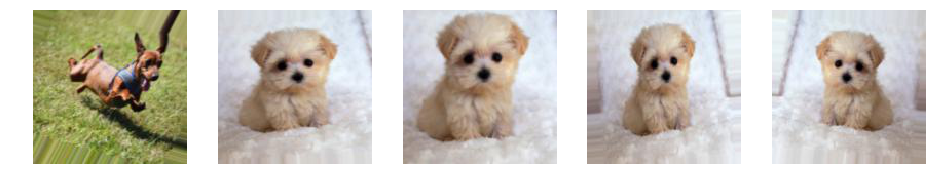

In [93]:
img_list = [name for name in os.listdir(aug_dir) 
                     if os.path.isfile(os.path.join(aug_dir, name))]

sample_img = []
f, axarr = plt.subplots(1,5, figsize=(16, 6))

for i in range(5):
    axarr[i].imshow(imread(os.path.join(aug_dir, img_list[i])))
    axarr[i].set_axis_off()
plt.show()

### Training

Data augmentation parameters

In [81]:
batch_size = 32
img_width, img_height = 150, 150
channels = 3
rotation_range = 5
shear_range = 0.2
zoom_range = 0.2
horizontal_flip=True

In [82]:
train_data_gen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
                                    featurewise_std_normalization=False, samplewise_std_normalization=True, 
                                    zca_whitening=False, zca_epsilon=1e-06, rotation_range=rotation_range, 
                                    width_shift_range=0.0, height_shift_range=0.0, 
                                    brightness_range=None, shear_range=shear_range, zoom_range=zoom_range, 
                                    channel_shift_range=0.0, fill_mode='nearest', cval=0.0, 
                                    horizontal_flip=horizontal_flip, vertical_flip=False, rescale=None, 
                                    preprocessing_function=None, data_format='channels_last', validation_split=None, dtype=None)

flow_from_directory creates some issues because of reading in images. Using flow instead so we can first create an array of images. Once properly cleaned flow_from_directory can be used if necessary. flow requires a pre-loaded array of data. This provides a chance to have greater control of the import and investigate any errors with readouts for the user to then clean.

In [13]:
import warnings

def read_images(img_dir, num_samples, img_height, img_width, channels):
    
    ''' Read in and create array of images with target labels '''
    
    Images = np.zeros((num_samples, img_height, img_width, channels))
    y_list = []
    index = 0
    
    for item in folder_list:
        ListOfFileNames = [name for name in os.listdir(img_dir+'\\'+item) 
                         if os.path.isfile(os.path.join(img_dir+'\\'+item, name))]
        print(len(ListOfFileNames))
        
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            
            for _,file in enumerate(ListOfFileNames):
                try:
                    img = imread(os.path.join(img_dir,item, file))

                    img = resize(img, (img_height,img_width,channels), mode='reflect', anti_aliasing=True)
                    Images[index] = img_as_float(img)
                    index+=1
                    y_list.append(item)
                except Warning:
                    print(os.path.join(img_dir,item, file))
            
    return Images, y_list

In [37]:
def one_hot_encoder(data):
    values = np.array(data)
    encoder = LabelEncoder()
    return encoder.fit(values)

In [36]:
def one_hot_converter(data, encoder):
    values = np.array(data)
    encoded_Y = encoder.transform(values)
    dummy_y = np_utils.to_categorical(encoded_Y)
    return dummy_y.astype(np.uint8)

In [14]:
train_dir = r'D:\Docs\Python_code\DogHotDogNotDog\Data\Train_data'

In [44]:
train_Images, y_train = read_images(train_dir, train_samples, img_height, img_width, channels)

997
810
807


View random image

2614


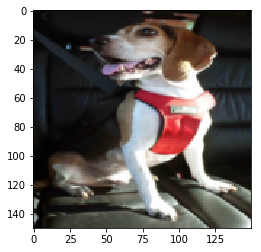

In [45]:
import random
print(len(train_Images))
plt.imshow(train_Images[random.randint(0, len(train_Images))])
plt.show()

In [46]:
encoder = one_hot_encoder(y_train)

In [47]:
dummy_y_train = one_hot_converter(y_train, encoder)

In [48]:
encoded_Y_train = encoder.transform(np.array(y_train))
print(encoder.inverse_transform(encoded_Y_train)[0])

"""Train:

encoder = LabelEncoder()
encoder.fit(X)
numpy.save('classes.npy', encoder.classes_)
Test

encoder = LabelEncoder()
encoder.classes_ = numpy.load('classes.npy')
# Now you should be able to use encoder
# as you would do after `fit`

"""

cute_dog


In [49]:
print(dummy_y_train[0])

[1 0 0]


In [50]:
train_generator = train_data_gen.flow(train_Images, dummy_y_train, batch_size=batch_size, 
                                      shuffle=True, sample_weight=None, seed=None, 
                                      save_to_dir=None, save_prefix='', save_format='jpg', subset=None)

In [74]:
val_dir = 'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data'
samples = 0
val_samples = 0
for item in folder_list:
    samples = len([name for name in os.listdir(val_dir+'\\'+item) 
                     if os.path.isfile(os.path.join(val_dir+'\\'+item, name))])
    val_samples += samples
    print(item, samples)

cute_dog 214
hot_dog 215
not_dog 226


In [65]:
val_Images, y_val = read_images(val_dir, val_samples, img_height, img_width, channels)

218
239
226


In [66]:
dummy_y_val = one_hot_converter(y_val, encoder)

In [67]:
val_datagen = ImageDataGenerator(samplewise_std_normalization=True)
validation_generator = val_datagen.flow(val_Images, dummy_y_val, batch_size=batch_size, 
                                      shuffle=True, sample_weight=None, seed=None, 
                                      save_to_dir=None, save_prefix='', save_format='jpg', subset=None)

C:\Users\Robin\Anaconda3\envs\CuteDog\lib\site-packages\keras_preprocessing\image.py:855: UserWarning: This ImageDataGenerator specifies `samplewise_std_normalization`, which overrides setting of `samplewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


## The Model

In [55]:
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout
from keras.models import Model

In [56]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Max pooling :is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing it’s dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

Batch Normalization: normalization (shifting inputs to zero-mean and unit variance) is often used as a pre-processing step to make the data comparable across features. This therefore leads to higher learning rate and better speed.

In [57]:
#Functional
def DogModel(input_shape):
    """
    Implementation of the MyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3,3))(X_input)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), strides = (2, 2), name='max_pool')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), strides = (2, 2), name='max_pool1')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv2')(X)
    X = BatchNormalization(axis = 3, name = 'bn2')(X)
    X = Activation('relu')(X)
    
    # MAXPOOL
    X = MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)
    
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(128, activation='relu', name='fc128')(X)
    X = Dense(64, activation='relu', name='fc64')(X)
    X = Dense(32, activation='relu', name='fc32')(X)
    X = Dropout(0.1)(X)
    X = Dense(3, activation='softmax', name='fc_final')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='MyModel')
    
    
    return model

In [58]:
MyModel = DogModel(input_shape = input_shape)

In [59]:
MyModel.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [68]:
# Functional
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
checkpoint = ModelCheckpoint('Model\model_best_weights.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto', period=1)

MyModel.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=val_samples // batch_size,
        callbacks = [early_stop,checkpoint])

# serialize model to JSON
model_json = MyModel.to_json()
with open("Model\model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
MyModel.save_weights("Model\model.h5")
print("Saved model to disk")

Epoch 1/50
81/81 [==============================] - 15s 189ms/step - loss: 0.2363 - acc: 0.9056 - val_loss: 0.8531 - val_acc: 0.7381

Epoch 00001: val_acc improved from -inf to 0.73810, saving model to Model\model_best_weights.h5
Epoch 2/50
81/81 [==============================] - 15s 186ms/step - loss: 0.2648 - acc: 0.8984 - val_loss: 0.6775 - val_acc: 0.7849

Epoch 00002: val_acc improved from 0.73810 to 0.78495, saving model to Model\model_best_weights.h5
Epoch 3/50
81/81 [==============================] - 15s 185ms/step - loss: 0.2683 - acc: 0.8988 - val_loss: 0.7276 - val_acc: 0.7650

Epoch 00003: val_acc did not improve from 0.78495
Epoch 4/50
81/81 [==============================] - 15s 185ms/step - loss: 0.2191 - acc: 0.9167 - val_loss: 0.7785 - val_acc: 0.7619

Epoch 00004: val_acc did not improve from 0.78495
Epoch 5/50
81/81 [==============================] - 15s 185ms/step - loss: 0.2071 - acc: 0.9203 - val_loss: 0.6977 - val_acc: 0.7757

Epoch 00005: val_acc did not improv

In [62]:
MyModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 156, 156, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 154, 154, 32)      896       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 154, 154, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 154, 154, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 77, 77, 32)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        9248      
__________

## Prediction
Let's check the accuracy and application of the model. It is important to apply the same pre-processing used in training. This was sample wise normalization which is division by the std. A couple example test images:

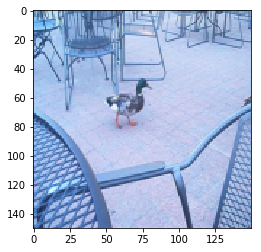

[[0.23551238 0.00734413 0.7571435 ]]
['not_dog']


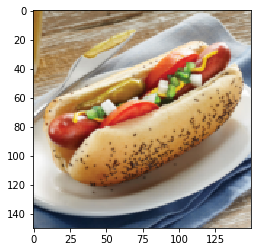

[[3.0213921e-05 9.9990630e-01 6.3545420e-05]]
['hot_dog']


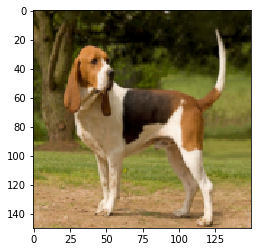

[[9.8857468e-01 5.1045474e-05 1.1374286e-02]]
['cute_dog']


In [96]:
#Prediction
from keras.models import load_model

# Returns a compiled model identical to the previous one
model = load_model('Model\model_best_weights.h5')

datagen = ImageDataGenerator(samplewise_std_normalization=True,
        rotation_range=rotation_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        fill_mode='nearest')

test_img = [r'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data\not_dog\IM000907_115.jpg',
           r'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data\hot_dog\9eebd4f328344b1fbeb0b5d7d4c18b10.jpg',
           r'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data\cute_dog\hound dog_31.jpg']

for _ in test_img:
    img = imread(_)
    
    img = resize(img, (img_height,img_width,channels), mode='reflect', anti_aliasing=True)
    
    plt.imshow(img)
    plt.show()

    test_Image = img_as_float(datagen.standardize(img))
    new_test = test_Image.reshape((1,) + test_Image.shape) 
    prediction = model.predict(new_test)
    print(prediction)
    print(encoder.inverse_transform(np.argmax(prediction, axis=1))) #[np.where(r==1)[0][0] for r in prediction]

In [84]:
validation_data_dir = 'D:\Docs\Python_code\DogHotDogNotDog\Data\Val_data'
generator = datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
probabilities = model.predict_generator(
        generator, val_samples // batch_size)

Found 655 images belonging to 3 classes.


In [85]:
probabilities

array([[7.3435336e-01, 9.7859578e-05, 2.6554874e-01],
       [9.9857199e-01, 2.7603523e-06, 1.4252390e-03],
       [9.9860424e-01, 1.0622311e-06, 1.3946657e-03],
       ...,
       [2.7897268e-06, 1.2078537e-13, 9.9999726e-01],
       [2.2851818e-03, 3.7794169e-07, 9.9771440e-01],
       [5.8592442e-02, 3.2444932e-05, 9.4137514e-01]], dtype=float32)

In [86]:
from sklearn.metrics import confusion_matrix

y_pred = probabilities > 0.5
y_true = dummy_y_val[:len(y_pred)]

In [87]:
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

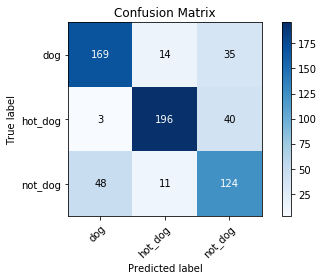

In [88]:
classes = ['dog', 'hot_dog', 'not_dog']
cmap=plt.cm.Blues
title = 'Confusion Matrix'
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()

Found 2621 images belonging to 3 classes.


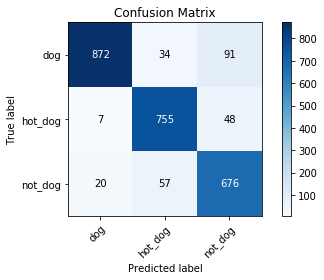

In [97]:
# train_data_dir = 'D:\Docs\Python_code\DogHotDogNotDog\Data\Train_data'
# generator = datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode=None,
#     shuffle=False)
# probabilities = model.predict_generator(
#         generator, train_samples // batch_size)

# y_pred = probabilities > 0.5
# y_true = dummy_y_train[:len(y_pred)]

# cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))

# classes = ['dog', 'hot_dog', 'not_dog']
# cmap=plt.cm.Blues
# title = 'Confusion Matrix'
# fig, ax = plt.subplots()
# im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
# ax.figure.colorbar(im, ax=ax)
# # We want to show all ticks...
# ax.set(xticks=np.arange(cm.shape[1]),
#        yticks=np.arange(cm.shape[0]),
#        # ... and label them with the respective list entries
#        xticklabels=classes, yticklabels=classes,
#        title=title,
#        ylabel='True label',
#        xlabel='Predicted label')

# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# # Loop over data dimensions and create text annotations.
# fmt = 'd'
# thresh = cm.max() / 2.
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         ax.text(j, i, format(cm[i, j], fmt),
#                 ha="center", va="center",
#                 color="white" if cm[i, j] > thresh else "black")
# fig.tight_layout()
# plt.show()

In [ ]:
# train_generator = train_data_gen.flow_from_directory(train_dir, target_size=(img_width, img_height), 
#                                      color_mode='rgb', classes=None, class_mode='categorical', 
#                                      batch_size=batch_size, shuffle=True, seed=None, 
#                                      save_prefix='', save_format='jpg', follow_links=False, 
#                                      subset=None, interpolation='nearest')

# # this is a similar generator, for validation data
# validation_generator = val_datagen.flow_from_directory(
#         val_dir,
#         target_size=(img_width, img_height),
#         batch_size=batch_size,
#         class_mode='categorical')

# Sequential
# model = Sequential()
# model.add(Conv2D(16, (3, 3), input_shape=input_shape))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dense(32))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(3)) 
# model.add(Activation('softmax')) #For multiclass

# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy']) #For multiclass

# #Sequential
# from keras.callbacks import EarlyStopping, ModelCheckpoint

# early_stop = EarlyStopping(monitor='loss', min_delta=0.001, patience=3, mode='min', verbose=1)
# checkpoint = ModelCheckpoint('model_best_weights.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto', period=1)

# model.fit_generator(
#         train_generator,
#         steps_per_epoch=train_samples // batch_size,
#         epochs=25,
#         validation_data=validation_generator,
#         validation_steps=val_samples // batch_size,
#         callbacks = [early_stop,checkpoint])
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")